### Project Overview


#### Contents:

1. Build a Database and Save Data into It
2. Load Data from Database
3. Extract Data from Database and Data Preprocessing
4. Data Analysis
5. Build and Evaluate ARIMA Forecast Model

#### Objective
Develop a comprehensive sales forecasting system to predict future sales patterns using historical data, with robust data management and real-time updating capabilities.


In [ ]:
# Import required libraries

import importlib
import subprocess

def install_and_import(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call(["pip", "install", package])
    finally:
        globals()[package] = importlib.import_module(package)

# List of required packages
required_packages = {
    "pandas": "pd",
    "numpy": "np",
    "matplotlib.pyplot": "plt",
    "sqlite3": "sqlite3",
    "sklearn.model_selection": "train_test_split",
    "sklearn.metrics": "mean_absolute_error",
    "statsmodels.tsa.arima.model": "ARIMA",
    "pmdarima": "auto_arima"
}

for package, alias in required_packages.items():
    module_name = package.split(".")[0]
    install_and_import(module_name)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


In [11]:
# Build a Database and Load Data

# Step 1: Generate Example Sales Data and Save to CSV
def generate_sales_data(file_path):
    np.random.seed(42)
    dates = pd.date_range(start="2020-01-01", end="2022-12-31", freq="D")
    sales = np.random.randint(100, 500, size=len(dates))
    data = pd.DataFrame({"date": dates, "sales": sales})
    data.to_csv(file_path, index=False)
    print(f"Example sales data saved to {file_path}")

# Generate and save example data
example_file_path = "sales_data.csv"
generate_sales_data(example_file_path)

# Step 2: Build a Database and Load Data into It
def build_database(db_name, csv_file_path):
    # Create SQLite database
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    # Create a sales table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS sales (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT,
        sales INTEGER
    )
    """)

    # Load data from CSV into the database
    data = pd.read_csv(csv_file_path)
    data.to_sql("sales", conn, if_exists="replace", index=False)
    print(f"Data loaded into the database {db_name}")

    conn.commit()
    conn.close()

# Build database and load data
database_name = "sales_forecasting.db"
build_database(database_name, example_file_path)

# Step 3: Load Data from Database
def load_data_from_db(db_name):
    conn = sqlite3.connect(db_name)
    query = "SELECT * FROM sales"
    data = pd.read_sql_query(query, conn)
    conn.close()
    print("Data Loaded Successfully from Database")
    return data

# Load data from database
original_data = load_data_from_db(database_name)
print(original_data.head(10))


Example sales data saved to sales_data.csv
Data loaded into the database sales_forecasting.db
Data Loaded Successfully from Database
         date  sales
0  2020-01-01    202
1  2020-01-02    448
2  2020-01-03    370
3  2020-01-04    206
4  2020-01-05    171
5  2020-01-06    288
6  2020-01-07    120
7  2020-01-08    202
8  2020-01-09    221
9  2020-01-10    314


In [12]:
# Step 4: Extract Data and Data Preprocessing
def preprocess_data(data):
    # Handle missing values
    data = data.dropna()

    # Remove duplicates
    data = data.drop_duplicates()

    # Clean outliers (e.g., remove sales values outside 3 standard deviations)
    mean_sales = data['sales'].mean()
    std_sales = data['sales'].std()
    data = data[(data['sales'] >= mean_sales - 3 * std_sales) & (data['sales'] <= mean_sales + 3 * std_sales)]

    # Standardize formats
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])
        data = data.sort_values(by='date')

    # Validate data types
    assert data['sales'].dtype == np.int64, "Sales column must be of type integer"
    
    # Create time-based features
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['day_of_week'] = data['date'].dt.dayofweek

    # Generate seasonal indicators
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Calculate moving averages
    data['moving_avg_7'] = data['sales'].rolling(window=7).mean()
    data['moving_avg_30'] = data['sales'].rolling(window=30).mean()

    # Create lag features
    data['lag_1'] = data['sales'].shift(1)
    data['lag_7'] = data['sales'].shift(7)

    # Implement interaction features
    data['month_sales_interaction'] = data['month'] * data['sales']

    # Generate categorical encodings
    data = pd.get_dummies(data, columns=['month', 'day_of_week'], drop_first=True)

    # Drop rows with NaN values introduced by lag or rolling operations
    data = data.dropna()

    print("Data Cleaning and Preprocessing Completed")
    return data

# Preprocess the data
if original_data is not None:
    processed_data = preprocess_data(original_data)

print(processed_data.head(10))

Data Cleaning and Preprocessing Completed
         date  sales  year  is_weekend  moving_avg_7  moving_avg_30  lag_1  \
29 2020-01-30    335  2020           0    306.857143     308.433333  352.0   
30 2020-01-31    444  2020           0    328.714286     316.500000  335.0   
31 2020-02-01    148  2020           1    296.142857     306.500000  444.0   
32 2020-02-02    158  2020           1    281.571429     299.433333  148.0   
33 2020-02-03    269  2020           0    261.000000     301.533333  158.0   
34 2020-02-04    287  2020           0    284.714286     305.400000  269.0   
35 2020-02-05    370  2020           0    287.285714     308.133333  287.0   
36 2020-02-06    289  2020           0    280.714286     313.766667  370.0   
37 2020-02-07    274  2020           0    256.428571     316.166667  289.0   
38 2020-02-08    150  2020           1    256.714286     313.800000  274.0   

    lag_7  month_sales_interaction  month_2  ...  month_9  month_10  month_11  \
29  485.0         

In [ ]:
# Step 5: Data Analysis
def pattern_analysis(data):
    print("Pattern Analysis:")

    # Identify seasonal patterns
    monthly_sales = data.groupby(data['date'].dt.month)['sales'].mean()
    plt.figure(figsize=(12, 6))
    plt.bar(monthly_sales.index, monthly_sales.values)
    plt.title('Average Sales by Month (Seasonality)')
    plt.xlabel('Month')
    plt.ylabel('Average Sales')
    plt.show()

    # Analyze trends
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['sales'], label='Sales')
    plt.title('Sales Trend Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    # Detect cyclical components
    data['rolling_avg_30'] = data['sales'].rolling(window=30).mean()
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['sales'], label='Sales')
    plt.plot(data['date'], data['rolling_avg_30'], label='30-Day Rolling Average', linestyle='--')
    plt.title('Cyclical Components')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    print("Pattern Analysis Completed")

# Perform pattern analysis
if processed_data is not None:
    pattern_analysis(processed_data)



In [ ]:

# Step 6: Build and Evaluate ARIMA Forecast Model
def arima_forecast(data):
    if 'date' in data.columns and 'sales' in data.columns:
        data = data.set_index('date', inplace=False)

        # Split data into training and test sets
        train_data = data['sales'][:int(0.8 * len(data))]
        test_data = data['sales'][int(0.8 * len(data)):] 

        # Fit ARIMA model
        # model = ARIMA(train_data, order=(7, 1, 0))  # Example order, can be tuned
        # fitted_model = model.fit()
        # Forecast
        # forecast = fitted_model.forecast(steps=len(test_data))
        model = auto_arima(data['sales'], 
                   seasonal=False, 
                   stepwise=True, 
                   suppress_warnings=True,
                   error_action="ignore", 
                   trace=True)

        print(model.summary())
        
        forecast = model.predict(n_periods=len(test_data))

        # Evaluate performance using MAE
        mae = mean_absolute_error(test_data, forecast)
        print(f"ARIMA Model Mean Absolute Error (MAE): {mae}")

        # Plot actual vs predicted
        plt.figure(figsize=(12, 6))
        plt.plot(test_data.index, test_data.values, label='Actual Sales')
        plt.plot(test_data.index, forecast, label='Forecasted Sales', linestyle='--')
        plt.title('Actual vs Forecasted Sales')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()
    else:
        print("Ensure 'date' and 'sales' columns exist in the data")

# Build and evaluate ARIMA model
if processed_data is not None:
    arima_forecast(processed_data)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12312.952, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11035.271, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11735.893, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10876.547, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=10753.836, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=10723.198, Time=0.16 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=1.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=10518.964, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=10520.028, Time=0.10 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=10520.185, Time=0.22 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=10520.9

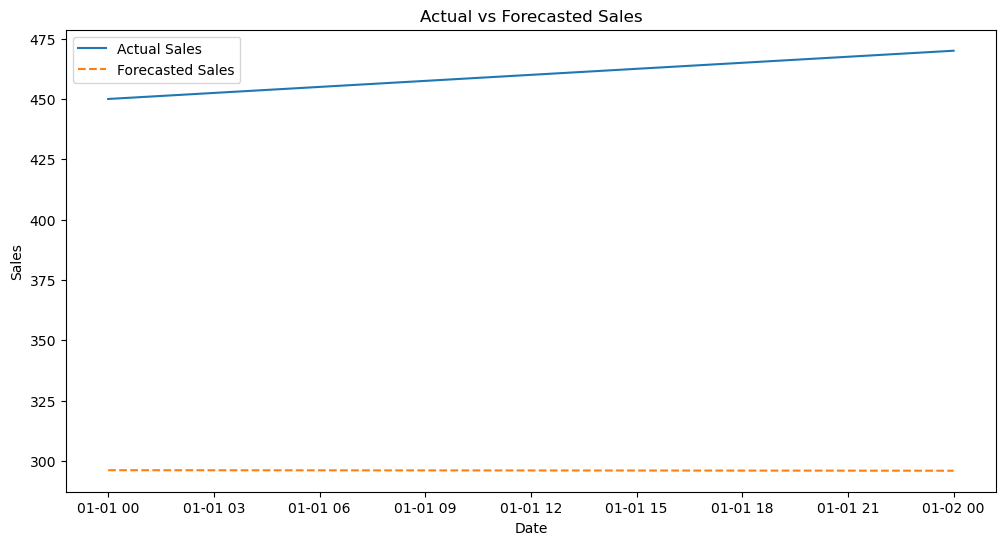

In [15]:

# Step 5: Real-Time Sales Forecasting with ARIMA
def arima_real_time_forecasting(data, new_data=None):
    if 'date' in data.columns and 'sales' in data.columns:
        data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' is datetime
        data = data.set_index('date', inplace=False)

        # Update with new data if provided
        if new_data is not None:
            new_data['date'] = pd.to_datetime(new_data['date'])  # Convert new data dates to datetime
            new_data.set_index('date', inplace=True)
            data = pd.concat([data, new_data])

        # Ensure data is sorted by date
        data = data.sort_index()

        # Split data into training and test sets
        train_data = data['sales'][:int(0.8 * len(data))]
        test_data = data['sales'][int(0.8 * len(data)):] if new_data is None else new_data

        # Fit ARIMA model using auto_arima
        model = auto_arima(
            train_data,
            seasonal=False,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore",
            trace=True
        )

        print(model.summary())

        # Forecast next steps based on provided new data or future periods
        forecast_steps = len(test_data) if test_data is not None else len(new_data)
        forecast = model.predict(n_periods=forecast_steps)

        # Evaluate performance if test data exists
        if test_data is not None:
            mae = mean_absolute_error(test_data, forecast)
            print(f"ARIMA Model Mean Absolute Error (MAE): {mae}")

            # Plot actual vs predicted
            plt.figure(figsize=(12, 6))
            plt.plot(test_data.index, test_data.values, label='Actual Sales')
            plt.plot(test_data.index, forecast, label='Forecasted Sales', linestyle='--')
            plt.title('Actual vs Forecasted Sales')
            plt.xlabel('Date')
            plt.ylabel('Sales')
            plt.legend()
            plt.show()
        else:
            print("Forecast for the new data provided:")
            print(forecast)

        return model, forecast
    else:
        print("Ensure 'date' and 'sales' columns exist in the data")

# Perform real-time forecasting
new_sales_data = pd.DataFrame({"date": ["2023-01-01", "2023-01-02"], "sales": [450, 470]})
if processed_data is not None:
    arima_real_time_forecasting(processed_data, new_sales_data)